In [128]:
import numpy as np
from towbintools.foundation.image_handling import read_tiff_file
import os
import matplotlib.pyplot as plt
import cv2
from skimage.util import img_as_ubyte
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

from skimage import (
    data, restoration, util
)

from joblib import Parallel, delayed
import warnings
from towbintools.foundation.file_handling import get_dir_filemap, add_dir_to_experiment_filemap
warnings.filterwarnings('ignore')

# increase font size for all plots
plt.rcParams.update({'font.size': 17})

In [129]:
# def get_data_from_ecdysis(filemap, epidermis_class=1, intestinal_class=2):
#     ecdysis = ['HatchTime', 'M1', 'M2', 'M3', 'M4']
#     datapoints_epidermis = {}
#     datapoints_intestinal = {}
#     for ecdys in ecdysis:
#         ecdys_epidermis_datapoints = []
#         ecdys_intestinal_datapoints = []
#         # exclude the points that have no ecdysis data
#         for point in filemap['Point'].unique():
#             point_df = filemap[filemap['Point'] == point]
#             point_ecdys = point_df[ecdys].values[0]
#             if point_ecdys == '':
#                 continue
#             # keep only the rows with a non empty MeasurementPath
#             point_df = point_df[point_df['MeasurementPath'] != '']

#             point_df[f'TimeRelativeTo{ecdys}'] = (point_df['Time'] - point_ecdys)*10/60

#             for i, row in point_df.iterrows():
#                 measurements_path = row['MeasurementPath']
#                 measurements_df = pd.read_csv(measurements_path)
#                 # if class instead of Class, rename the column
#                 if 'class' in measurements_df.columns:
#                     measurements_df.rename(columns={'class': 'Class'}, inplace=True)

#                 count_epidermis = measurements_df[measurements_df['ClassID'] == epidermis_class]['Z'].value_counts()
#                 count_intestinal = measurements_df[measurements_df['ClassID'] == intestinal_class]['Z'].value_counts()

#                 if count_epidermis.size != 0 and count_epidermis.max() > 10:
#                     epidermis_plane = count_epidermis.idxmax()

#                     epidermis_df = measurements_df[measurements_df['Z'] == epidermis_plane]
#                     epidermis_df = epidermis_df[epidermis_df['ClassID'] == epidermis_class]
#                     # remove outliers
#                     epidermis_df = epidermis_df[epidermis_df['NucleusCytoplasmRatioMean'] >= 0]

#                     ecdys_epidermis_datapoints.append((row[f'TimeRelativeTo{ecdys}'], epidermis_df['NucleusCytoplasmRatioMean'].mean()))

#                 if count_intestinal.size != 0 and count_intestinal.max() > 5:
#                     intestinal_plane = count_intestinal.idxmax()

#                     intestinal_df = measurements_df[measurements_df['Z'] == intestinal_plane]
#                     intestinal_df = intestinal_df[intestinal_df['ClassID'] == intestinal_class]
#                     # remove outliers
#                     intestinal_df = intestinal_df[intestinal_df['NucleusCytoplasmRatioMean'] >= 0]

#                     ecdys_intestinal_datapoints.append((row[f'TimeRelativeTo{ecdys}'], intestinal_df['NucleusCytoplasmRatioMean'].mean()))

#         datapoints_epidermis[ecdys] = ecdys_epidermis_datapoints
#         datapoints_intestinal[ecdys] = ecdys_intestinal_datapoints

#     return datapoints_epidermis, datapoints_intestinal

def get_data_from_ecdysis(filemap, epidermis_class=1, intestinal_class=2, z_column = 'Z', class_column = 'ClassID', column_to_plot = 'NucleusCytoplasmRatioMean'):
    ecdysis = ['HatchTime', 'M1', 'M2', 'M3', 'M4']
    datapoints_epidermis = {}
    datapoints_intestinal = {}
    for ecdys in ecdysis:
        ecdys_epidermis_datapoints = []
        ecdys_intestinal_datapoints = []
        # exclude the points that have no ecdysis data
        for point in filemap['Point'].unique():
            point_df = filemap[filemap['Point'] == point]
            point_ecdys = point_df[ecdys].values[0]
            if point_ecdys == '':
                continue
            # keep only the rows with a non empty MeasurementPath
            point_df = point_df[point_df['MeasurementPath'] != '']

            point_df[f'TimeRelativeTo{ecdys}'] = (point_df['Time'] - point_ecdys)*10/60

            for i, row in point_df.iterrows():
                measurements_path = row['MeasurementPath']
                measurements_df = pd.read_csv(measurements_path)
                # if class instead of Class, rename the column
                if 'class' in measurements_df.columns:
                    measurements_df.rename(columns={'class': 'Class'}, inplace=True)

                count_epidermis = measurements_df[measurements_df[class_column] == epidermis_class][z_column].value_counts()

                count_intestinal = measurements_df[measurements_df[class_column] == intestinal_class][z_column].value_counts()


                if count_epidermis.size != 0 and count_epidermis.max() > 10:
                    epidermis_plane = count_epidermis.idxmax()

                    epidermis_df = measurements_df[measurements_df[z_column] == epidermis_plane]
                    epidermis_df = epidermis_df[epidermis_df[class_column] == epidermis_class]
                    # remove outliers
                    epidermis_df = epidermis_df[epidermis_df[column_to_plot] >= 0]

                    ecdys_epidermis_datapoints.append((row[f'TimeRelativeTo{ecdys}'], epidermis_df[column_to_plot].median()))

                if count_intestinal.size != 0 and count_intestinal.max() > 5:
                    intestinal_plane = count_intestinal.idxmax()

                    intestinal_df = measurements_df[measurements_df[z_column] == intestinal_plane]
                    intestinal_df = intestinal_df[intestinal_df[class_column] == intestinal_class]
                    # remove outliers
                    intestinal_df = intestinal_df[intestinal_df[column_to_plot] >= 0]

                    ecdys_intestinal_datapoints.append((row[f'TimeRelativeTo{ecdys}'], intestinal_df[column_to_plot].median()))

        datapoints_epidermis[ecdys] = ecdys_epidermis_datapoints
        datapoints_intestinal[ecdys] = ecdys_intestinal_datapoints

    return datapoints_epidermis, datapoints_intestinal

def get_ecdysis(filemap):
    all_ecdysis_time_step = []
    
    for point in filemap["Point"].unique():
        point_df = filemap[filemap["Point"] == point]
        point_ecdysis = point_df[["HatchTime", "M1", "M2", "M3", "M4"]].iloc[0]
    
        point_ecdysis = point_ecdysis.to_numpy()
        all_ecdysis_time_step.append(point_ecdysis)

    #replace the '' with np.nan
    all_ecdysis_time_step = np.array(all_ecdysis_time_step)
    all_ecdysis_time_step[all_ecdysis_time_step == ''] = np.nan
    all_ecdysis_time_step = all_ecdysis_time_step.astype(float)

    return all_ecdysis_time_step

In [130]:
# pad1_filemap_path = "/mnt/towbin.data/shared/spsalmon/20241115_122955_248_ZIVA_40x_raga1_full_deletion/analysis/report/pad1/analysis_filemap_annotated.csv"
# pad2_filemap_path = "/mnt/towbin.data/shared/spsalmon/20241115_122955_248_ZIVA_40x_raga1_full_deletion/analysis/report/pad2/analysis_filemap_annotated.csv"

# pad1_measurements_dir = '/mnt/towbin.data/shared/spsalmon/20241115_122955_248_ZIVA_40x_raga1_full_deletion/analysis/nuclear_stats_stardist/pad1'
# pad2_measurements_dir = '/mnt/towbin.data/shared/spsalmon/20241115_122955_248_ZIVA_40x_raga1_full_deletion/analysis/nuclear_stats_stardist/pad2'

pad2_filemap_path = "/mnt/towbin.data/shared/igheor/20241111_ZIVA_40x_vhp1_mStayGold_chambers_470_471_25C/analysis/report/analysis_filemap_annotated.csv"
pad2_measurements_dir = "/mnt/towbin.data/shared/igheor/20241111_ZIVA_40x_vhp1_mStayGold_chambers_470_471_25C/analysis/nuclear_stats_stardist/"

experiment_id = "vhp1_mStayGold"

epidermis_class = 1
intestinal_class = 2

z_column = 'Z'
class_column = 'ClassID'

# pad1_filemap_path = "/mnt/towbin.data/shared/spsalmon/20240628_153634_380_LIPSI_40x_397_405_new_round_chambers/analysis/report/pad1/pad1_filemap_annotated.csv"
# pad2_filemap_path = "/mnt/towbin.data/shared/spsalmon/20240628_153634_380_LIPSI_40x_397_405_new_round_chambers/analysis/report/pad2/pad2_filemap_annotated.csv"

# pad1_measurements_dir = '/mnt/towbin.data/shared/spsalmon/20240628_153634_380_LIPSI_40x_397_405_new_round_chambers/analysis/nuclei_stats_deep_learning/pad1'
# pad2_measurements_dir = '/mnt/towbin.data/shared/spsalmon/20240628_153634_380_LIPSI_40x_397_405_new_round_chambers/analysis/nuclei_stats_deep_learning/pad2'

# experiment_id = "col10TIR_raga_AID_deep_learning"

# epidermis_class = 0
# intestinal_class = 1

# z_column = 'Plane'
# class_column = 'Class'

# pad1_filemap = pd.read_csv(pad1_filemap_path)
pad2_filemap = pd.read_csv(pad2_filemap_path)

# pad1_filemap = add_dir_to_experiment_filemap(pad1_filemap, pad1_measurements_dir, 'MeasurementPath')
pad2_filemap = add_dir_to_experiment_filemap(pad2_filemap, pad2_measurements_dir, 'MeasurementPath')


# pads_filemaps = [pad1_filemap, pad2_filemap]
pads_filemaps = [pad2_filemap]
# pads_measurements_dirs = [pad1_measurements_dir, pad2_measurements_dir]
pads_measurements_dirs = [pad2_measurements_dir]

def filter_out_bad_positions(filemap, bad_columns):
    bad_columns = [column for column in bad_columns if column in filemap.columns]
    for point in filemap['Point'].unique():
        point_df = filemap[filemap['Point'] == point]
        for column in bad_columns:
            if len(point_df[column].unique()) > 1:
                filemap = filemap[filemap['Point'] != point]
    return filemap

bad_columns = ['OutOfFood', 'EscapeOrVisit', 'IgnorePoint', 'Dauer']

for i, filemap in enumerate(pads_filemaps):
    pads_filemaps[i] = filter_out_bad_positions(filemap, bad_columns)

In [131]:
epidermal_measurements = []
intestinal_measurements = []

column_to_plot = 'MeanIntensityAllNuclei'

for pad_filemap in pads_filemaps:
    epidermis, intestinal = get_data_from_ecdysis(pad_filemap, epidermis_class=epidermis_class, intestinal_class=intestinal_class, z_column=z_column, class_column=class_column, column_to_plot=column_to_plot)
    epidermal_measurements.append(epidermis)
    intestinal_measurements.append(intestinal)

In [132]:
for measurement in epidermal_measurements:
    print(measurement)

{'HatchTime': [], 'M1': [(-13.833333333333334, 60.53859100745372), (-12.833333333333334, 56.75303768580768), (-11.833333333333334, 53.5619964014707), (-10.833333333333334, 54.25368819037735), (-9.833333333333334, 58.68992180712424), (-8.833333333333334, 58.71717606543263), (-7.833333333333333, 59.61908517350157), (-6.833333333333333, 63.01775530601447), (-5.833333333333333, 57.78662182361734), (-4.833333333333333, 61.05235501132913), (-3.8333333333333335, 61.95128345832571), (-2.8333333333333335, 63.6252129471891), (-1.8333333333333333, 69.71604785222836), (-0.8333333333333334, 79.15696834362275), (0.16666666666666666, 81.75935082310511), (1.1666666666666667, 66.15198297718219), (2.1666666666666665, 67.97130183839248), (3.1666666666666665, 70.98208889621449), (4.166666666666667, 71.68548234849915), (5.166666666666667, 66.02251546391753), (6.166666666666667, 73.61009499503757), (7.166666666666667, 71.85516914552348), (8.166666666666666, 75.78869803502205), (9.166666666666666, 75.9661016

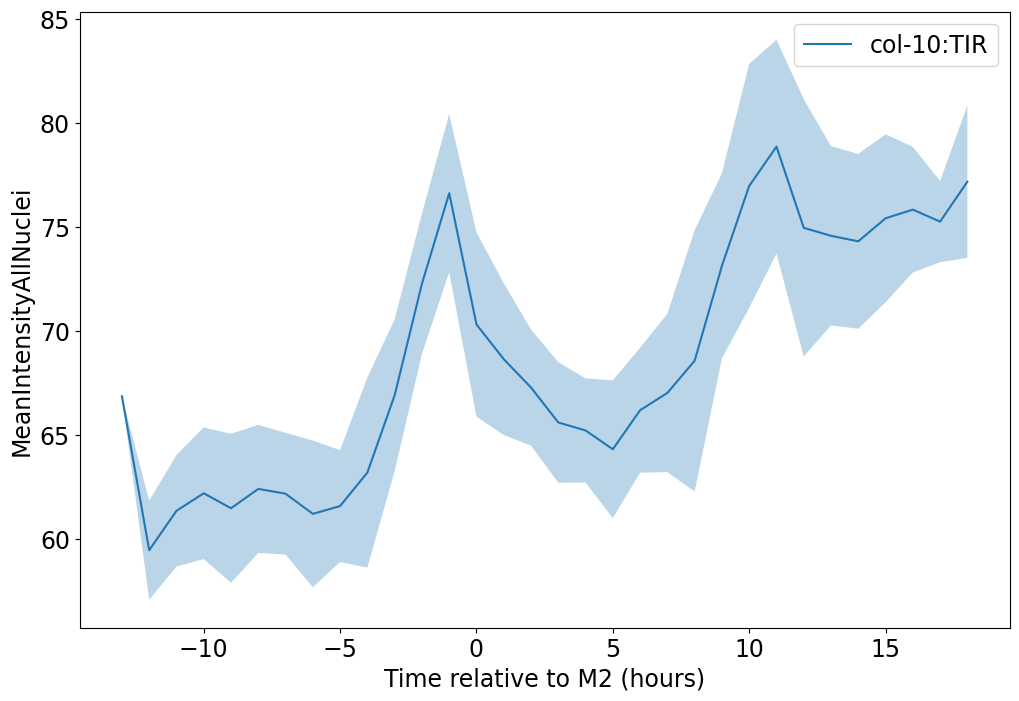

In [133]:
ecdys = 'M2'

# pad1_datapoints_to_plot, pad2_datapoints_to_plot = epidermal_measurements[0][ecdys], epidermal_measurements[1][ecdys]
pad2_datapoints_to_plot = epidermal_measurements[0][ecdys]

# sort the datapoints by the first element of the tuple
# pad1_datapoints_to_plot = sorted(pad1_datapoints_to_plot, key=lambda x: x[0])
pad2_datapoints_to_plot = sorted(pad2_datapoints_to_plot, key=lambda x: x[0])

# bin the datapoints between -11 and +11 hours
time_bins = np.arange(-20, 20, 1)
# time_bins = np.arange(0, 48, 1)

pad1_binned_datapoints = []
pad2_binned_datapoints = []

# for i in range(len(time_bins) - 1):
#     pad1_binned_datapoints.append([x[1] for x in pad1_datapoints_to_plot if time_bins[i] <= x[0] < time_bins[i+1]])

for i in range(len(time_bins) - 1):
    pad2_binned_datapoints.append([x[1] for x in pad2_datapoints_to_plot if time_bins[i] <= x[0] < time_bins[i+1]])

means_pad1 = [np.mean(x) for x in pad1_binned_datapoints]
means_pad2 = [np.mean(x) for x in pad2_binned_datapoints]
stds_pad1 = [np.std(x) for x in pad1_binned_datapoints]
stds_pad2 = [np.std(x) for x in pad2_binned_datapoints]

plt.figure(figsize=(12, 8))
# plt.plot(time_bins[:-1], means_pad1, label='raga-1:delta')
# plt.fill_between(time_bins[:-1], np.array(means_pad1) - np.array(stds_pad1), np.array(means_pad1) + np.array(stds_pad1), alpha=0.3)

plt.plot(time_bins[:-1], means_pad2, label='col-10:TIR')
plt.fill_between(time_bins[:-1], np.array(means_pad2) - np.array(stds_pad2), np.array(means_pad2) + np.array(stds_pad2), alpha=0.3)
plt.xlabel(f'Time relative to {ecdys} (hours)')
plt.ylabel(column_to_plot)
# plt.title(f'Epidermal Nuclear/Cytoplasmic ratio over time relative to Hatch')
plt.legend()

plt.savefig(f'./plots/{experiment_id}_epidermal_{column_to_plot}_over_time_relative_to_{ecdys}.svg')
plt.show()

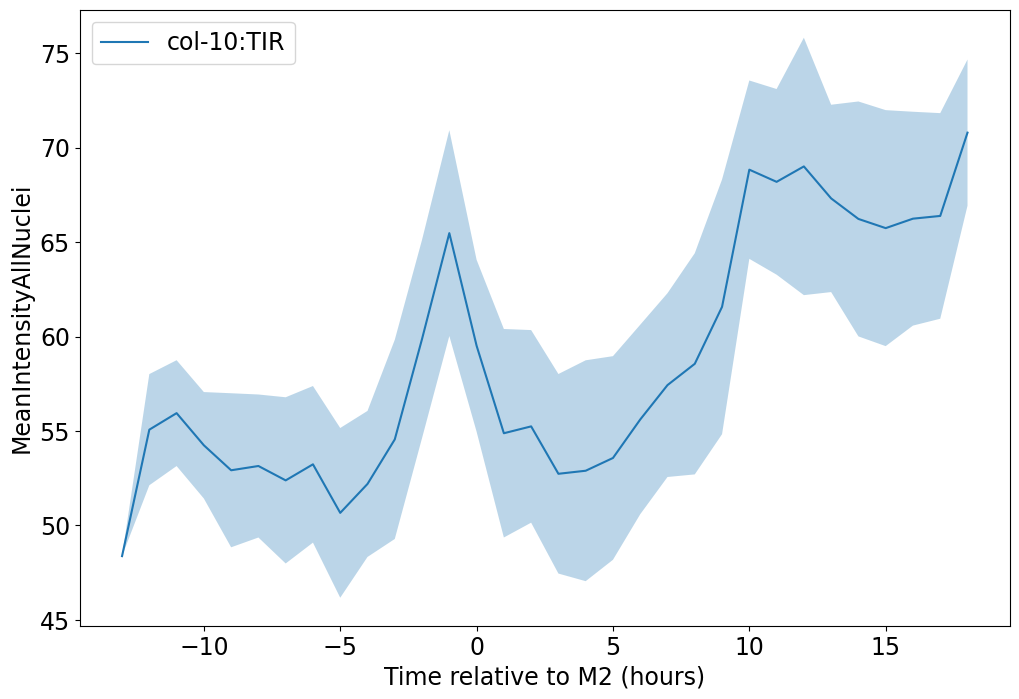

In [134]:
# pad1_datapoints_to_plot, pad2_datapoints_to_plot = intestinal_measurements[0][ecdys], intestinal_measurements[1][ecdys]
pad2_datapoints_to_plot = intestinal_measurements[0][ecdys]

# sort the datapoints by the first element of the tuple
# pad1_datapoints_to_plot = sorted(pad1_datapoints_to_plot, key=lambda x: x[0])
pad2_datapoints_to_plot = sorted(pad2_datapoints_to_plot, key=lambda x: x[0])

# bin the datapoints between -11 and +11 hours
# time_bins = np.arange(-15, 10, 1)
# time_bins = np.arange(0, 48, 1)

pad1_binned_datapoints = []
pad2_binned_datapoints = []

# for i in range(len(time_bins) - 1):
#     pad1_binned_datapoints.append([x[1] for x in pad1_datapoints_to_plot if time_bins[i] <= x[0] < time_bins[i+1]])

for i in range(len(time_bins) - 1):
    pad2_binned_datapoints.append([x[1] for x in pad2_datapoints_to_plot if time_bins[i] <= x[0] < time_bins[i+1]])

means_pad1 = [np.mean(x) for x in pad1_binned_datapoints]
means_pad2 = [np.mean(x) for x in pad2_binned_datapoints]
stds_pad1 = [np.std(x) for x in pad1_binned_datapoints]
stds_pad2 = [np.std(x) for x in pad2_binned_datapoints]

plt.figure(figsize=(12, 8))
# plt.plot(time_bins[:-1], means_pad1, label='raga-1:delta')
# plt.fill_between(time_bins[:-1], np.array(means_pad1) - np.array(stds_pad1), np.array(means_pad1) + np.array(stds_pad1), alpha=0.3)

plt.plot(time_bins[:-1], means_pad2, label='col-10:TIR')
plt.fill_between(time_bins[:-1], np.array(means_pad2) - np.array(stds_pad2), np.array(means_pad2) + np.array(stds_pad2), alpha=0.3)
plt.xlabel(f'Time relative to {ecdys} (hours)')
plt.ylabel(column_to_plot)
# plt.title(f'Intestinal Nuclear/Cytoplasmic ratio over time relative to Hatch')
plt.legend()

plt.savefig(f'./plots/{experiment_id}_intestinal_{column_to_plot}_over_time_relative_to_{ecdys}.svg')
plt.show()

In [135]:
def interpolate_larval_stage(time, series, ecdysis, larval_stage, n_points = 100):
    if larval_stage < 1 or larval_stage > 4:
        raise ValueError("The larval stage must be between 1 and 4.")
    
    previous_ecdys = ecdysis[larval_stage-1]
    ecdys = ecdysis[larval_stage]

    # check that the molts are correct
    if (np.isnan(previous_ecdys) or np.isnan(ecdys)) or previous_ecdys > ecdys:
        return np.full(n_points, np.nan), np.full(n_points, np.nan)
    
    # convert ecdysis times to int to get the index
    previous_ecdys = int(previous_ecdys)
    ecdys = int(ecdys)

    interpolated_time = np.linspace(previous_ecdys, ecdys, n_points)
    interpolated_series = interpolate.interp1d(time, series, kind='linear', fill_value='extrapolate')(interpolated_time)

    return interpolated_time, interpolated_series

def interpolate_entire_development(time, series, ecdysis, n_points = 100):
    interpolated_time = np.full((4, n_points), np.nan)
    interpolated_series = np.full((4, n_points), np.nan)
    for larval_stage in range(1, 5):
        interpolated_time_stage, interpolated_series_stage = interpolate_larval_stage(time, series, ecdysis, larval_stage, n_points)
        
        interpolated_time[larval_stage - 1, :] = interpolated_time_stage
        interpolated_series[larval_stage - 1, :] = interpolated_series_stage

    return interpolated_time, interpolated_series

In [136]:
# def interpolate_yap_dynamics(filemap, epidermis_class=1, intestinal_class=2):
#     ecdysis = get_ecdysis(filemap)

#     epidermal_interpolated_time = []
#     epidermal_interpolated_series = []
#     intestinal_interpolated_time = []
#     intestinal_interpolated_series = []

#     for idx, point in enumerate(filemap['Point'].unique()):
#         point_df = filemap[filemap['Point'] == point]
#         # keep only the rows with a non empty MeasurementPath
#         point_df = point_df[point_df['MeasurementPath'] != '']

#         point_epidermal = []
#         point_intestinal = []

#         for i, row in point_df.iterrows():
#             measurements_path = row['MeasurementPath']
#             measurements_df = pd.read_csv(measurements_path)
#             # if class instead of Class, rename the column
#             if 'class' in measurements_df.columns:
#                 measurements_df.rename(columns={'class': 'Class'}, inplace=True)

#             count_epidermis = measurements_df[measurements_df['ClassID'] == epidermis_class]['Z'].value_counts()
#             count_intestinal = measurements_df[measurements_df['ClassID'] == intestinal_class]['Z'].value_counts()

#             if count_epidermis.size != 0 and count_epidermis.max() > 10:
#                 epidermis_plane = count_epidermis.idxmax()

#                 epidermis_df = measurements_df[measurements_df['Z'] == epidermis_plane]
#                 epidermis_df = epidermis_df[epidermis_df['ClassID'] == epidermis_class]
#                 # remove outliers
#                 epidermis_df = epidermis_df[epidermis_df['NucleusCytoplasmRatioMean'] >= 0]

#                 point_epidermal.append((row['Time'], epidermis_df['NucleusCytoplasmRatioMean'].mean()))

#             if count_intestinal.size != 0 and count_intestinal.max() > 5:
#                 intestinal_plane = count_intestinal.idxmax()

#                 intestinal_df = measurements_df[measurements_df['Z'] == intestinal_plane]
#                 intestinal_df = intestinal_df[intestinal_df['ClassID'] == intestinal_class]
#                 # remove outliers
#                 intestinal_df = intestinal_df[intestinal_df['NucleusCytoplasmRatioMean'] >= 0]

#                 point_intestinal.append((row['Time'], intestinal_df['NucleusCytoplasmRatioMean'].mean()))
                
#         time_epidermal, series_epidermal = interpolate_entire_development(np.array([x[0] for x in point_epidermal]), np.array([x[1] for x in point_epidermal]), ecdysis[idx], n_points=25)
#         time_intestinal, series_intestinal = interpolate_entire_development(np.array([x[0] for x in point_intestinal]), np.array([x[1] for x in point_intestinal]), ecdysis[idx], n_points=25)

#         epidermal_interpolated_time.append(time_epidermal)
#         epidermal_interpolated_series.append(series_epidermal)

#         intestinal_interpolated_time.append(time_intestinal)
#         intestinal_interpolated_series.append(series_intestinal)

#     return epidermal_interpolated_time, epidermal_interpolated_series, intestinal_interpolated_time, intestinal_interpolated_series

def interpolate_yap_dynamics(filemap, epidermis_class=1, intestinal_class=2):
    ecdysis = get_ecdysis(filemap)

    epidermal_interpolated_time = []
    epidermal_interpolated_series = []
    intestinal_interpolated_time = []
    intestinal_interpolated_series = []

    for idx, point in enumerate(filemap['Point'].unique()):
        point_df = filemap[filemap['Point'] == point]
        # keep only the rows with a non empty MeasurementPath
        point_df = point_df[point_df['MeasurementPath'] != '']

        point_epidermal = []
        point_intestinal = []

        for i, row in point_df.iterrows():
            measurements_path = row['MeasurementPath']
            measurements_df = pd.read_csv(measurements_path)
            # if class instead of Class, rename the column
            if 'class' in measurements_df.columns:
                measurements_df.rename(columns={'class': 'Class'}, inplace=True)

            count_epidermis = measurements_df[measurements_df['ClassID'] == epidermis_class]['Z'].value_counts()
            count_intestinal = measurements_df[measurements_df['ClassID'] == intestinal_class]['Z'].value_counts()

            if count_epidermis.size != 0 and count_epidermis.max() > 10:
                epidermis_plane = count_epidermis.idxmax()

                epidermis_df = measurements_df[measurements_df['Z'] == epidermis_plane]
                epidermis_df = epidermis_df[epidermis_df['ClassID'] == epidermis_class]
                # remove outliers
                epidermis_df = epidermis_df[epidermis_df['NucleusCytoplasmRatioMean'] >= 0]

                point_epidermal.append((row['Time'], epidermis_df['NucleusCytoplasmRatioMean'].median()))

            if count_intestinal.size != 0 and count_intestinal.max() > 5:
                intestinal_plane = count_intestinal.idxmax()

                intestinal_df = measurements_df[measurements_df['Z'] == intestinal_plane]
                intestinal_df = intestinal_df[intestinal_df['ClassID'] == intestinal_class]
                # remove outliers
                intestinal_df = intestinal_df[intestinal_df['NucleusCytoplasmRatioMean'] >= 0]

                point_intestinal.append((row['Time'], intestinal_df['NucleusCytoplasmRatioMean'].median()))
                
        time_epidermal, series_epidermal = interpolate_entire_development(np.array([x[0] for x in point_epidermal]), np.array([x[1] for x in point_epidermal]), ecdysis[idx], n_points=25)
        time_intestinal, series_intestinal = interpolate_entire_development(np.array([x[0] for x in point_intestinal]), np.array([x[1] for x in point_intestinal]), ecdysis[idx], n_points=25)

        epidermal_interpolated_time.append(time_epidermal)
        epidermal_interpolated_series.append(series_epidermal)

        intestinal_interpolated_time.append(time_intestinal)
        intestinal_interpolated_series.append(series_intestinal)

    return epidermal_interpolated_time, epidermal_interpolated_series, intestinal_interpolated_time, intestinal_interpolated_series

In [137]:
# pad1_epidermal_interpolated_time, pad1_epidermal_interpolated_series, pad1_intestinal_interpolated_time, pad1_intestinal_interpolated_series = interpolate_yap_dynamics(pad1_filemap, epidermis_class = 1, intestinal_class = 2)
# pad2_epideral_interpolated_time, pad2_epidermal_interpolated_series, pad2_intestinal_interpolated_time, pad2_intestinal_interpolated_series = interpolate_yap_dynamics(pad2_filemap)

epidermal_interpolated_times = []
epidermal_interpolated_series = []
intestinal_interpolated_times = []
intestinal_interpolated_series = []

for pad_filemap in pads_filemaps:
    # Get interpolated values from function
    e_time, e_series, i_time, i_series = interpolate_yap_dynamics(pad_filemap)
    
    print(np.array(e_time).shape)
    print(np.array(e_series).shape)
    
    # Append the results to our collection lists
    epidermal_interpolated_times.append(e_time)
    epidermal_interpolated_series.append(e_series)
    intestinal_interpolated_times.append(i_time)
    intestinal_interpolated_series.append(i_series)

(41, 4, 25)
(41, 4, 25)


(41, 4, 25)
(41, 4, 25)


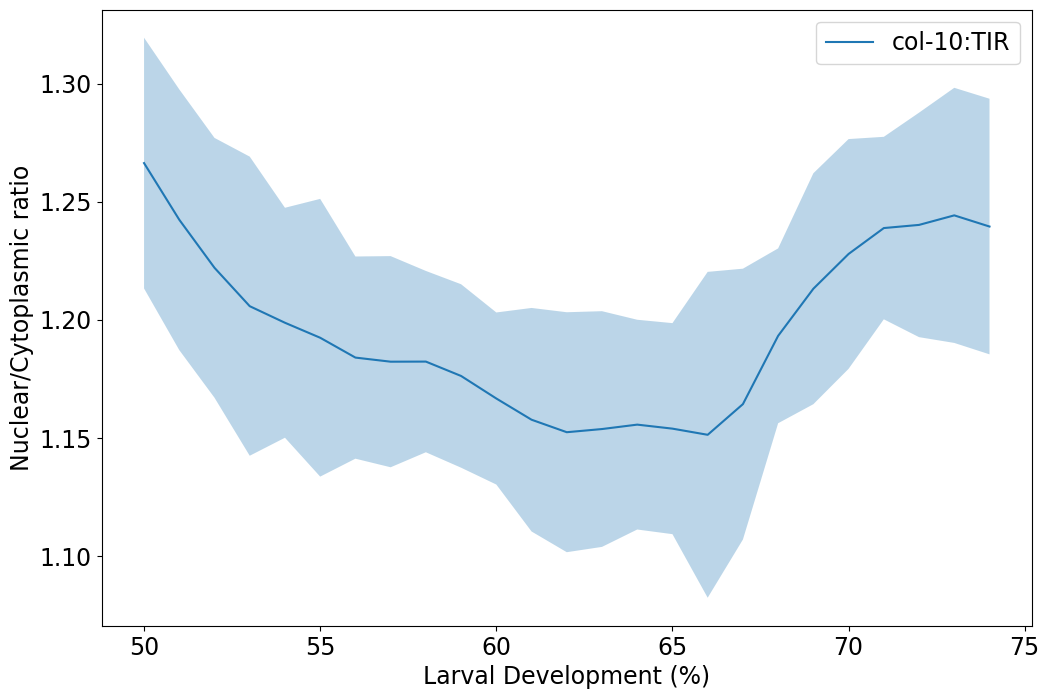

In [138]:
def aggregated_yap_dynamics(interpolated_series, n_points = 25, aggregation_function = np.nanmean):
    aggregated_series = np.full((4, n_points), np.nan)
    std_series = np.full((4, n_points), np.nan)
    ste_series = np.full((4, n_points), np.nan)

    print(interpolated_series.shape)

    for i in range(4):
        aggregated_series[i, :] = aggregation_function(interpolated_series[:, i, :], axis=0)
        std_series[i, :] = np.nanstd(interpolated_series[:, i, :], axis=0)
        ste_series[i, :] = np.nanstd(interpolated_series[:, i, :], axis=0) / np.sqrt(np.sum(np.isfinite(interpolated_series[:, i, :])))

    aggregated_series = aggregated_series.flatten()
    std_series = std_series.flatten()
    ste_series = ste_series.flatten()

    return aggregated_series, std_series, ste_series

# pad2_epidermal_aggregated_series, pad2_epidermal_std_series, pad2_epidermal_ste_series = aggregated_yap_dynamics(np.array(epidermal_interpolated_series[1]))
# pad2_intestinal_aggregated_series, pad2_intestinal_std_series, pad2_intestinal_ste_series = aggregated_yap_dynamics(np.array(intestinal_interpolated_series[1]))

pad1_epidermal_aggregated_series, pad1_epidermal_std_series, pad1_epidermal_ste_series = aggregated_yap_dynamics(np.array(epidermal_interpolated_series[0]))
pad1_intestinal_aggregated_series, pad1_intestinal_std_series, pad1_intestinal_ste_series = aggregated_yap_dynamics(np.array(intestinal_interpolated_series[0]))

x = np.arange(100)
plt.figure(figsize=(12, 8))
plt.plot(pad1_epidermal_aggregated_series, label='col-10:TIR')
plt.fill_between(x , pad1_epidermal_aggregated_series - pad1_epidermal_std_series, pad1_epidermal_aggregated_series + pad1_epidermal_std_series, alpha=0.3)
# plt.plot(pad2_epidermal_aggregated_series,  label='WT raga-1')
# plt.fill_between(x , pad2_epidermal_aggregated_series - pad2_epidermal_std_series, pad2_epidermal_aggregated_series + pad2_epidermal_std_series, alpha=0.3)

plt.xlabel('Larval Development (%)')
plt.ylabel('Nuclear/Cytoplasmic ratio')
# plt.title('Epidermal Nuclear/Cytoplasmic ratio over development')

plt.legend()
plt.savefig(f'./plots/{experiment_id}_epidermal_nuclear_cytoplasmic_ratio_over_development.svg')
plt.show()



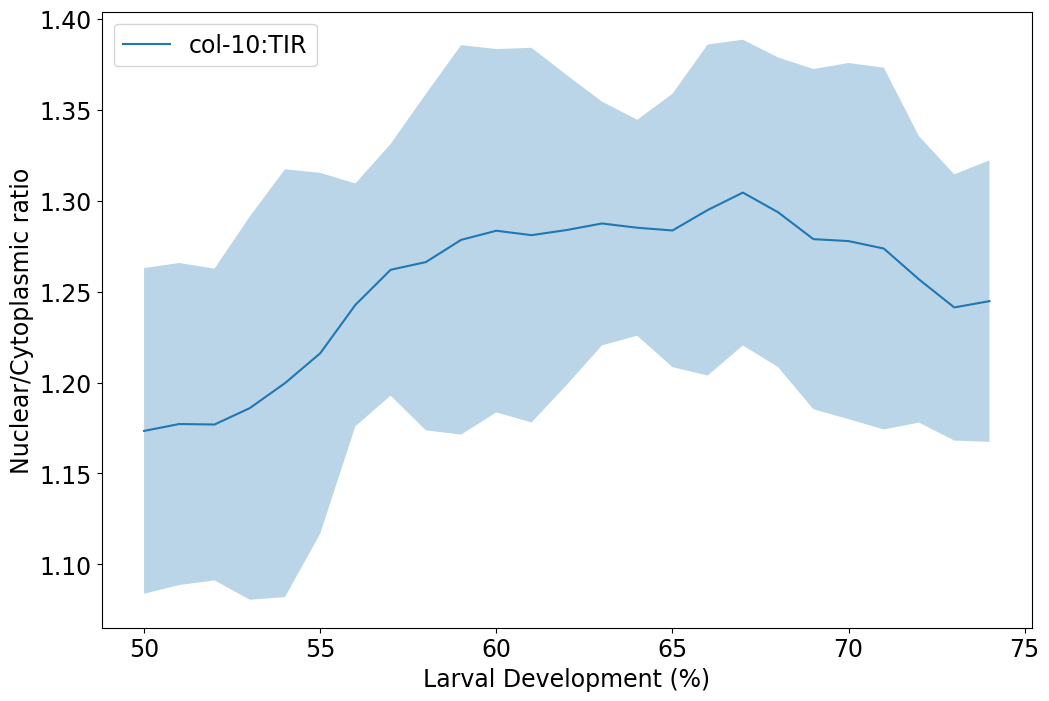

In [139]:
x = np.arange(100)
plt.figure(figsize=(12, 8))
plt.plot(pad1_intestinal_aggregated_series, label='col-10:TIR')
plt.fill_between(x , pad1_intestinal_aggregated_series - pad1_intestinal_std_series, pad1_intestinal_aggregated_series + pad1_intestinal_std_series, alpha=0.3)

# plt.plot(pad2_intestinal_aggregated_series, label='WT raga-1')
# plt.fill_between(x , pad2_intestinal_aggregated_series - pad2_intestinal_std_series, pad2_intestinal_aggregated_series + pad2_intestinal_std_series, alpha=0.3)

plt.xlabel('Larval Development (%)')
plt.ylabel('Nuclear/Cytoplasmic ratio')
# plt.title('Intestinal Nuclear/Cytoplasmic ratio over development')

plt.legend()
plt.savefig(f'./plots/{experiment_id}_intestinal_nuclear_cytoplasmic_ratio_over_development.svg')
plt.show()